# Clustering

In [1]:
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as shc
from sklearn.preprocessing import StandardScaler

from scripts.utils import *
from scripts.figure_params import *

from funcs.plots import ClusterPlotter

### Load data and remove participants with nans

In [2]:
# read in data and remove subjects with nans
fig_dir = get_path('figures')

data = pd.read_pickle(os.path.join(get_path("dataframes"), "sigmoid_data.pkl"))
p50_data = data.dros.path_duplicates("distance_p50")
p50_data.loc[p50_data.paradigm == 'Bayesian', 'paradigm'] = 'Randomized'  # fix label

df = p50_data.set_index(["paradigm", "pred"])[["participant", "distance_p50"]]
table = df.pivot_table(index=df.index, columns="participant", values="distance_p50")
table.index = [", ".join(x) for x in table.index]
table = table.dros.pathna(axis=1)

In [3]:
zscore = True

### Normalization

In [4]:
# Perform z-scoring
if zscore:
    scaler = StandardScaler()
    table = pd.DataFrame(scaler.fit_transform(table),
                                    columns=table.columns,
                                    index=table.index)

### Dimensionality reduction

In [5]:
pca = PCA()
pcs = pca.fit_transform(table)
cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()

print(cumulative_explained_variance)

n_pcs = np.argwhere(cumulative_explained_variance >= 0.95)[0][0] + 1

print(f"\nLet's keep the first {n_pcs} components ! (cumulative explained variance ≥ 95%)")

[0.61384557 0.78558711 0.86832997 0.91011406 0.94050302 0.96681599
 0.98528476 0.99421685 1.         1.        ]

Let's keep the first 6 components ! (cumulative explained variance ≥ 95%)


### Plot the Principal Components

(for cumulative explained variance ≥ 95%)

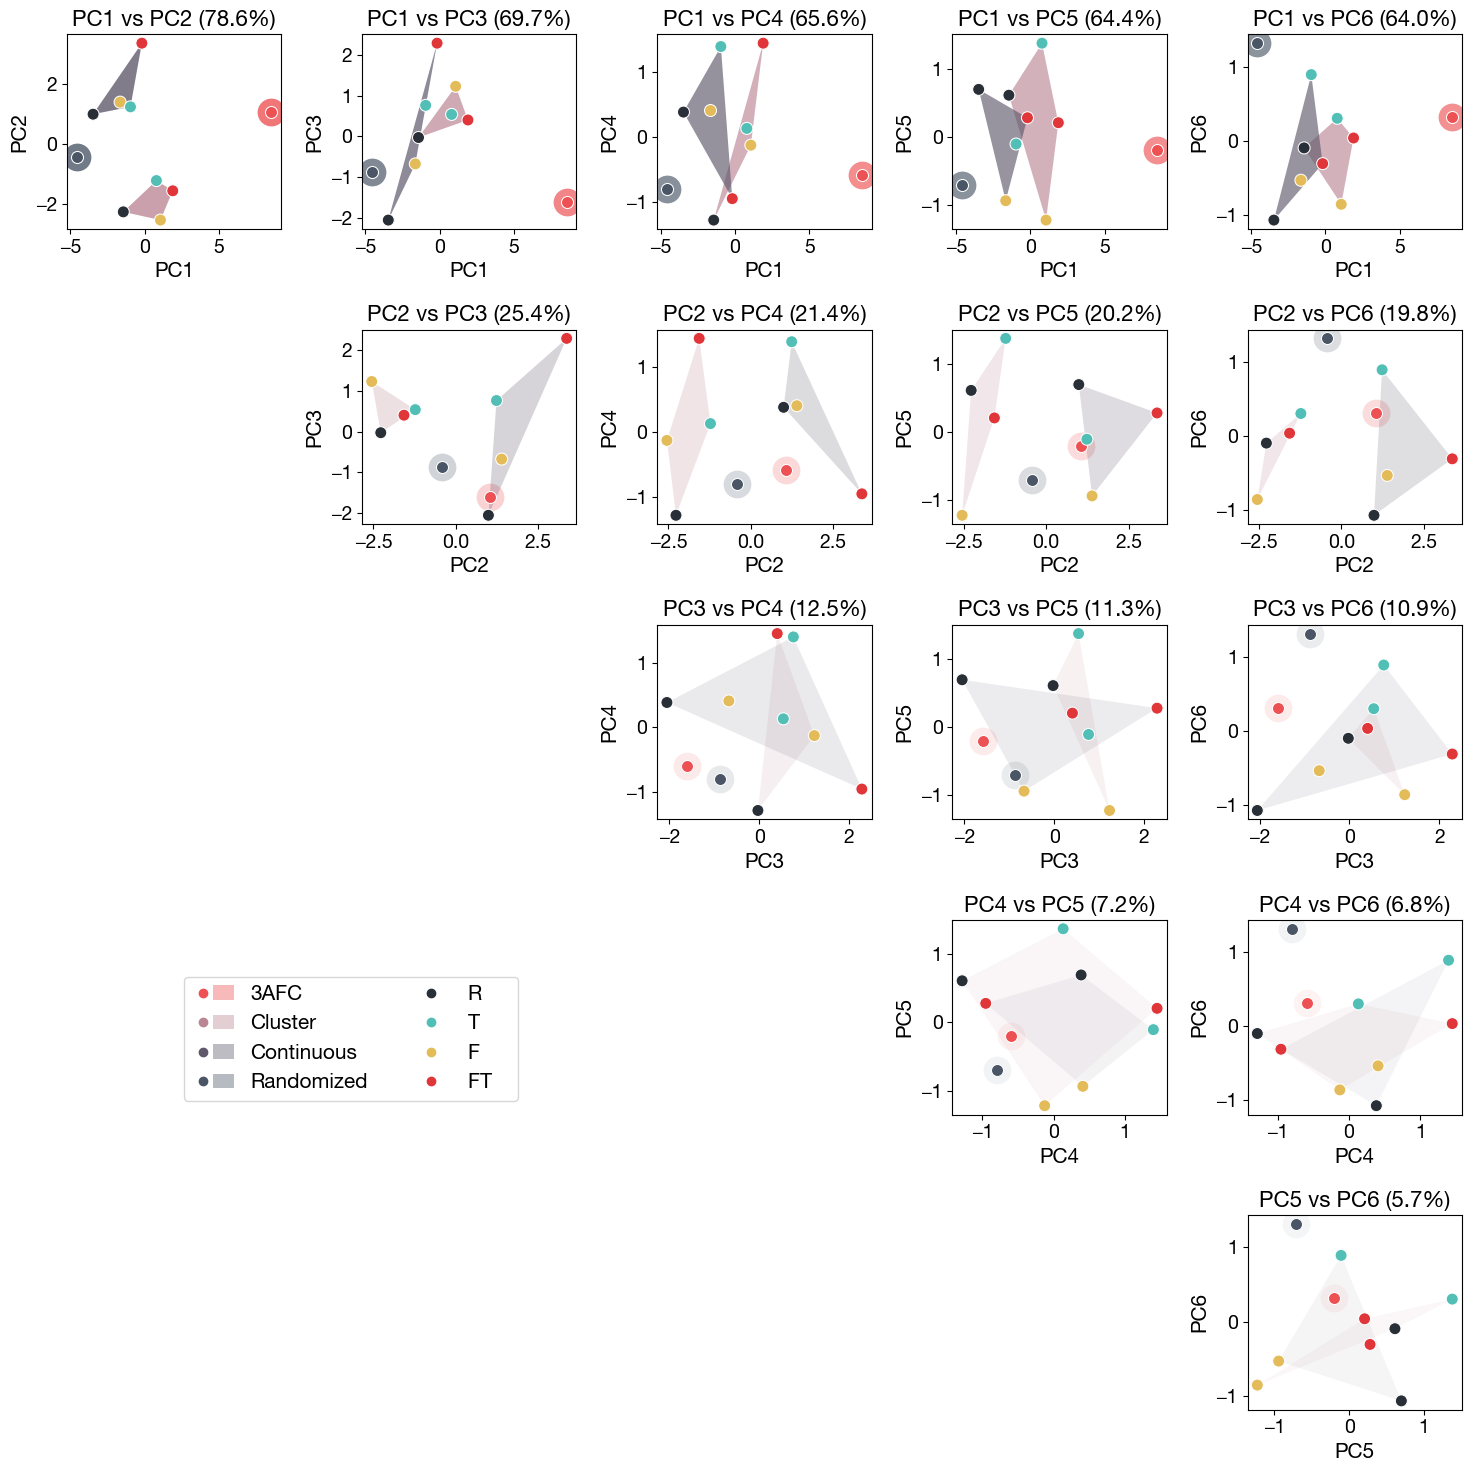

In [6]:
fig = ClusterPlotter().plot_pcs(table, pca, pcs, n_pcs)

### Dendogram

In [7]:
selected_data = pcs[:, :n_pcs]  # if you don't want to reduce dimensions:  # table
print(selected_data.shape)

clusters = shc.linkage(selected_data, method="average", metric="cosine")

# Compute the dendrogram
dendrogram = shc.dendrogram(Z=clusters, labels=table.index, no_plot=True)

(10, 6)


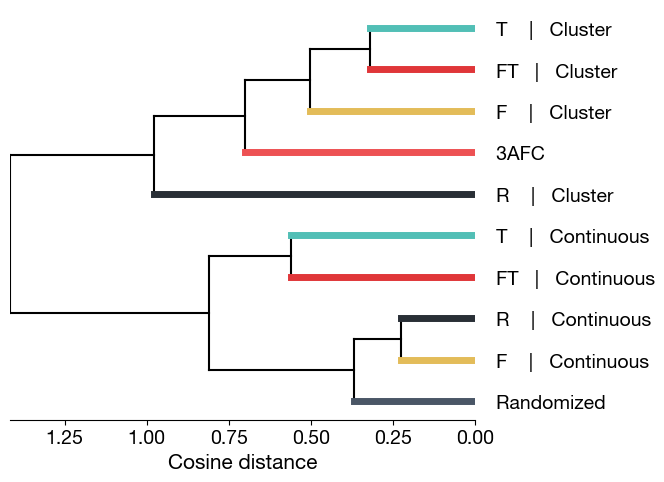

In [8]:
fig = ClusterPlotter().plot_dendrogram(clusters, dendrogram, table)
fig.savefig(os.path.join(get_path('figures'), 'Fig4B-paradigm_clustering.svg'))